In [123]:
# Install necessary packages
import warnings
warnings.simplefilter('ignore')
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install pandas_datareader
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install plotly
!{sys.executable} -m pip install scipy

### Import Necessary Libraries

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import norm
import seaborn as sns
sns.set()

## Portfolio Construction

#### CAPM for initial filtering of S&P500

In [3]:
# Load ticker data and 5 Year monthly stock data

tickers = pd.read_excel('data/tickers.xlsx', index_col=0)
stocks_df = pd.read_excel('data/stock_data_20.6.2017-21.7.2022.xlsx', index_col='Date')

print(tickers.info())
print(stocks_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 503 entries, 0 to 502
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Symbol                 503 non-null    object
 1   Security               503 non-null    object
 2   SEC filings            503 non-null    object
 3   GICS Sector            503 non-null    object
 4   GICS Sub-Industry      503 non-null    object
 5   Headquarters Location  503 non-null    object
 6   Date first added       458 non-null    object
 7   CIK                    503 non-null    int64 
 8   Founded                503 non-null    object
dtypes: int64(1), object(8)
memory usage: 39.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 2017-06-01 to 2022-07-01
Columns: 501 entries, MMM to ^GSPC
dtypes: float64(501)
memory usage: 243.2 KB
None


In [4]:
# Number of companies in S&P500 by sector
tickers.iloc[:,3].value_counts()

Information Technology    74
Industrials               73
Financials                66
Health Care               64
Consumer Discretionary    58
Consumer Staples          33
Real Estate               31
Utilities                 29
Materials                 28
Communication Services    26
Energy                    21
Name: GICS Sector, dtype: int64

In [5]:
# Extract companies and their respective sector
sectors = tickers[['Symbol','GICS Sector']]
sectors.rename(columns={'Symbol':'symbol', 'GICS Sector':'sector'}, inplace=True)
sectors.set_index('symbol', inplace=True)

In [6]:
# Extract the list of tickers and store as a list
tick = stocks_df.columns.to_list()

In [7]:
# Create returns
returns = stocks_df.pct_change()
returns.head()

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
2017-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-01,-0.033719,-0.049352,0.011726,-0.035857,0.033426,0.041559,0.073128,0.019333,0.035704,0.167124,...,-0.076386,-0.035640,0.039097,0.023453,0.023319,0.011938,-0.053301,0.032111,0.003949,0.019349
2017-08-01,0.015658,0.042656,0.041519,0.086781,0.018300,0.015060,0.061185,-0.020389,0.059185,-0.104617,...,-0.025009,0.074610,0.046290,0.094130,0.021897,0.013468,-0.058111,-0.036629,0.002879,0.000546
2017-09-01,0.033219,0.067157,0.047507,0.180080,0.118037,0.032961,-0.016016,0.036708,-0.038541,0.026768,...,0.114264,0.075574,-0.044040,0.012000,-0.041786,0.053254,0.024678,0.083513,0.016906,0.019303
2017-10-01,0.096665,-0.003870,0.016305,0.015643,0.144247,0.053972,0.015191,-0.038579,0.174152,0.069123,...,0.099861,-0.009602,0.054212,0.062271,0.011412,0.068245,0.040902,-0.015261,0.000941,0.022188


In [8]:
# Here we will calculate the 5y beta - we can check these values against those displayed in yahoo finance but it must be noted
# our values will differ slightly. Randomly checking 10 symbols highlighted an accurate comparison between these and yahoo

cov = returns.cov()
var = returns['^GSPC'].var()

beta = cov.loc['^GSPC']/var
beta

MMM      0.933650
AOS      1.148805
ABT      0.724539
ABBV     0.726712
ABMD     1.340498
           ...   
ZBRA     1.615763
ZBH      1.174467
ZION     1.270956
ZTS      0.726414
^GSPC    1.000000
Name: ^GSPC, Length: 501, dtype: float64

In [9]:
# Compute the market return that accounts for compouding effects and is annualized.

num_years = stocks_df.index.year[-1] - stocks_df.index.year[0]
print('Number of years in this data:',num_years, '\n')

total_return = (stocks_df['^GSPC'][-1] - stocks_df['^GSPC'][0]) / stocks_df['^GSPC'][0]
print("Total Return for the S&P500 =",str(round(total_return * 100,2)) + '%', '\n')

# Annualized Return for S&P500
annualized_return_y = ((1+total_return)**(1/5))-1
print('Market return is', str(round(annualized_return_y,3)*100) + '%')

Number of years in this data: 5 

Total Return for the S&P500 = 65.01% 

Market return is 10.5%


In [10]:
# You can find the risk free rate at:
# https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value_month=202207

rfr = 0.0291 # risk free rate on 10y treasury as of 21/7/2022 is 2.91%
market_return = 0.105
expected_return_capm = rfr + beta*(market_return - rfr)
expected_return_capm

MMM      0.099964
AOS      0.116294
ABT      0.084093
ABBV     0.084257
ABMD     0.130844
           ...   
ZBRA     0.151736
ZBH      0.118242
ZION     0.125566
ZTS      0.084235
^GSPC    0.105000
Name: ^GSPC, Length: 501, dtype: float64

##### Check if stocks are overpriced, underpriced or fairly priced based on the systematic risk as indicated by the CAPM

In [11]:
total_returns = []
annualized_returns = []

#Compute total return
for ticker in tick:
    tot_of_ret = (stocks_df[ticker][-1] - stocks_df[ticker][0])/stocks_df[ticker][0]
    total_returns.append(tot_of_ret)

#compute annualized returns (expected return of asset) to be compared with expected return of the CAPM
for i in range(len(tick)):
    num_years = stocks_df.index.year[-1] - stocks_df.index.year[0]
    annual_ret = ((1 + total_returns[i])**(1/num_years))-1
    annualized_returns.append(annual_ret)

**We will use the following formula to highlight companies above or below the Capital Market Line**: 
Alpha = annualized stock return - CAPM benchmark

In [12]:
# Jensen's alpha: positive alpha indicates assets that are underpriced and negative indicates overpriced

alpha = annualized_returns - expected_return_capm
beta['rfr'] = 0
expected_return_capm['rfr'] = rfr
alpha['rfr'] = rfr

alpha = pd.DataFrame(alpha)
alpha.rename(columns={'^GSPC':'Alpha'}, inplace=True)
alpha

,Alpha
MMM,-0.154831
AOS,-0.090114
ABT,0.111412
ABBV,0.123857
ABMD,0.013900
...,...
ZBH,-0.138418
ZION,-0.065405
ZTS,0.159696
^GSPC,0.000360


**Theoretic CAPM Visualisation** 
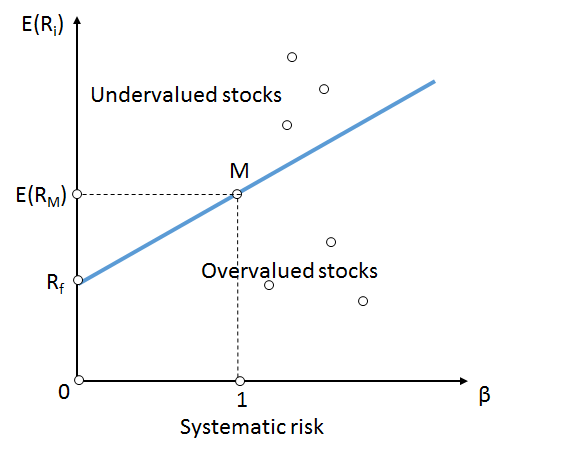

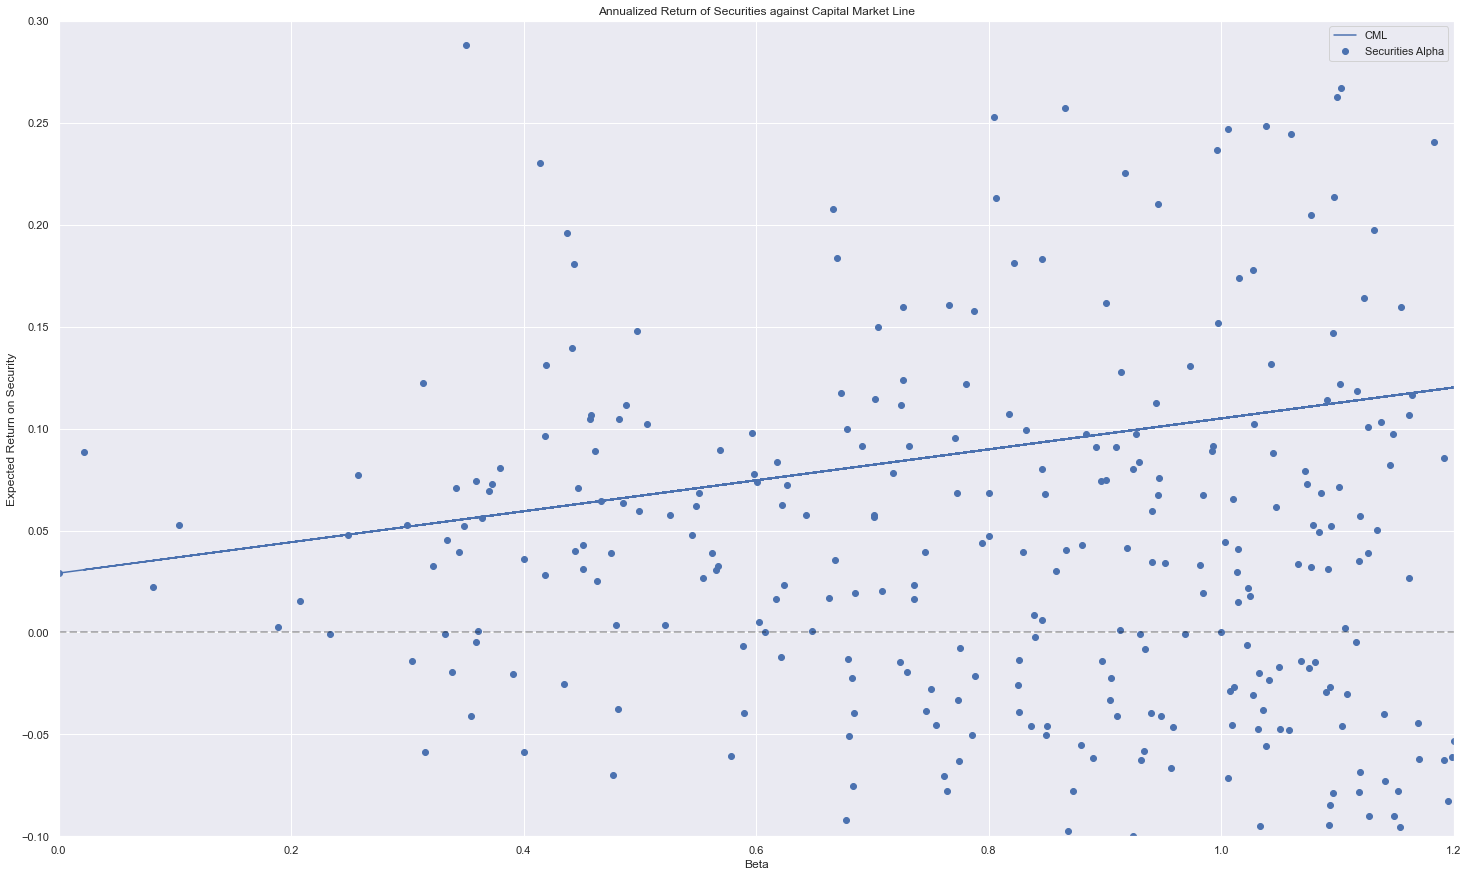

In [13]:
# Visualise the CAPM

plt.figure(figsize=(25, 15))
plt.plot(beta, expected_return_capm, color='b',  label='CML')
plt.scatter(beta, alpha, label='Securities Alpha')

plt.grid(True)
plt.xlim([0.0, 1.2])
plt.ylim([-0.1, 0.3])
plt.axhline(0, color='k', ls='--', lw=2.0, alpha=0.3)
plt.legend()
plt.xlabel('Beta')
plt.ylabel('Expected Return on Security')
plt.title('Annualized Return of Securities against Capital Market Line')
plt.show()

# Securities above the capital market line are known to be underpriced in relation to the systematic risk as indicated by the
# CAPM beta. These securities appear to have an expected return greater than the minimum amount of return an investor should
# be willing to take given the expected return highlighted by the CAPM.
# Whilst it may be difficult to see, a larger proportion of stocks fall below the capital market line which indicates that
# a large proportion of stocks in the S&P are overpriced, according to the CAPM. 
# It has been established since 2021 that tech stocks have been overvalued which could explain partly the the disproportion of 
# stocks overpriced to underpriced. We can also see that the capital market line has an intercept of 0.0291 which is equivalent 
# to the risk free rate. The slope of the capital market line is equivalent to: rfr + beta(market_return - rfr)

In [14]:
# Here we will take the top 200 alpha value stocks 

sorted_alpha = alpha.sort_values(by='Alpha', ascending=False)[:200]
sorted_alpha.head()

,Alpha
ENPH,1.892824
SEDG,0.602142
TSLA,0.432533
FTNT,0.406833
GNRC,0.350094


In [15]:
# Store the new ticker list
ticker_fundamentals = sorted_alpha.index.to_list()

### Load data & compute fundamental metric sector averages

In [16]:
# The data consists of 10 years of fundamentals in yearly format. Due to filings of companies being on different days
# we extract only the year.

ticker_financials = pd.read_excel('data/ticker_financials-mrq.xlsx', index_col='symbol') # yfinance api data
key_m = pd.read_excel('data/10y_fundamental_key-metrics.xlsx')
fund_ratios = pd.read_excel('data/10y_fundamental_ratios.xlsx')
fund_income_s = pd.read_excel('data/10y_fundamental_income-statement.xlsx')
discounted_cf = pd.read_excel('data/discounted_cash_flow_22-07-2022.xlsx', index_col='symbol')
piotroskiscore = pd.read_excel('data/piotroski_score.xlsx', index_col='symbol')
piotroskiscore = piotroskiscore[['piotroskiScore', 'marketCap']]

df_km = key_m
df_km['date'] = df_km['date'].dt.year
df_km = df_km.set_index('date')

df_ratio = fund_ratios
df_ratio['date'] = df_ratio['date'].dt.year
df_ratio = df_ratio.set_index('date')

tfinance = ticker_financials

df_fis = fund_income_s
df_fis['date'] = df_fis['date'].dt.year
df_fis = df_fis.set_index('date')

dcf = discounted_cf

###### Compute sector average for PEG Ratio and EV/R 2020-Q1 to 2021-Q4

In [17]:
peg_er = pd.merge(tfinance[['pegRatio','enterpriseToRevenue']], sectors, on=['symbol'])
peg_er = peg_er.dropna()
peg_er

,pegRatio,enterpriseToRevenue,sector
symbol,,,
MMM,2.10,2.478,Industrials
AOS,2.01,2.305,Industrials
ABT,1.79,4.504,Health Care
ABBV,36.40,5.927,Health Care
ABMD,15.33,11.066,Health Care
...,...,...,...
YUM,2.44,6.918,Consumer Discretionary
ZBRA,1.71,3.634,Information Technology
ZBH,2.63,4.235,Health Care


In [18]:
# Use interquartile range to remove outliers - the condition is +/- 2 * IQR

def outliers(df, feature):
    Q1= df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + 2 * IQR
    lower_limit = Q1 - 2 * IQR
    return upper_limit, lower_limit

In [19]:
features = ['pegRatio', 'enterpriseToRevenue']
for var in features:
    upper, lower = outliers(peg_er, var)
    peg_er = peg_er[(peg_er[var] > lower) & (peg_er[var] < upper)]
    print(var, ": Upper Limit:", round(upper,2), "Lower Limit:",round(lower,2))
    
# A negative PEG ratio can only mean that either the P/E ratio of the stock is negative, meaning that the company is 
# losing money or that the estimated growth rate for future earnings is negative, indicating that the earnings of the 
# company are expected to decrease in the future.

pegRatio : Upper Limit: 6.13 Lower Limit: -2.82
enterpriseToRevenue : Upper Limit: 13.81 Lower Limit: -6.16


In [20]:
unique_sect = peg_er['sector'].to_list()
unique_sect = np.unique(unique_sect)
unique_sect

array(['Communication Services', 'Consumer Discretionary',
       'Consumer Staples', 'Energy', 'Financials', 'Health Care',
       'Industrials', 'Information Technology', 'Materials',
       'Real Estate', 'Utilities'], dtype='<U22')

In [21]:
peg_er_list = []

for var in features:
    for sector in unique_sect:
        avg = np.mean(peg_er[var].loc[peg_er['sector'] == sector])
        std = np.std(peg_er[var].loc[peg_er['sector'] == sector])
        peg_er_list.append([var, sector, round(avg,2), round(std,2)])


peg_er_sectors = pd.DataFrame(peg_er_list)
peg_er_sectors.rename(columns={0:'Factor', 1:'sector', 2:'average', 3:'stddev'}, inplace=True)
peg_er_sectors = peg_er_sectors.set_index('Factor')
peg_er_sectors

,sector,average,stddev
Factor,,,
pegRatio,Communication Services,1.13,1.37
pegRatio,Consumer Discretionary,1.06,0.99
pegRatio,Consumer Staples,3.07,1.12
pegRatio,Energy,0.75,0.96
pegRatio,Financials,1.30,1.18
pegRatio,Health Care,1.51,1.37
pegRatio,Industrials,1.47,1.09
pegRatio,Information Technology,1.54,0.81
pegRatio,Materials,1.11,1.29


###### Compute sector average for Free Cash Flow Yield 2020-Q1 to 2021-Q4

In [22]:
# Free Cash Flow Yield

fcfy = pd.merge(df_km.loc[[2020,2021],['symbol','freeCashFlowYield']], sectors, on=['symbol'])
fcfy = fcfy.dropna()

upper, lower = outliers(fcfy, 'freeCashFlowYield')
fcfy = fcfy[(fcfy['freeCashFlowYield'] > lower) & (fcfy['freeCashFlowYield'] < upper)]
print("Free Cash Flow Yield: Upper Limit:", round(upper,2), "Lower Limit:",round(lower,2))

Free Cash Flow Yield: Upper Limit: 0.1 Lower Limit: -0.03


In [23]:
fcfy_list = []

for sector in unique_sect:
    avg = np.mean(fcfy['freeCashFlowYield'].loc[fcfy['sector'] == sector])
    std = np.std(fcfy['freeCashFlowYield'].loc[fcfy['sector'] == sector])
    fcfy_list.append(['freeCashFlowYield', sector, round(avg,4), round(std,4)])
    
fcfy_sectors = pd.DataFrame(fcfy_list)
fcfy_sectors.rename(columns={0:'Factor', 1:'sector', 2:'average', 3:'stddev'}, inplace=True)
fcfy_sectors = fcfy_sectors.set_index('Factor')
fcfy_sectors

,sector,average,stddev
Factor,,,
freeCashFlowYield,Communication Services,0.0267,0.0259
freeCashFlowYield,Consumer Discretionary,0.0395,0.0251
freeCashFlowYield,Consumer Staples,0.0402,0.0147
freeCashFlowYield,Energy,0.0423,0.0355
freeCashFlowYield,Financials,0.0426,0.0137
freeCashFlowYield,Health Care,0.0350,0.0254
freeCashFlowYield,Industrials,0.0392,0.0159
freeCashFlowYield,Information Technology,0.0306,0.0160
freeCashFlowYield,Materials,0.0370,0.0233


###### Compute sector average for EVMultiple, Op Profit Margin, ROE, D/E, P/FCF and P/B Ratio 2020-Q1 to 2021-Q4

In [24]:
ratios = df_ratio.loc[[2020,2021],:].set_index('symbol')

secondary_features = ['enterpriseValueMultiple',
                      'netProfitMargin',
                      'operatingProfitMargin',
                      'returnOnEquity',
                      'priceEarningsRatio',
                      'priceToFreeCashFlowsRatio',
                      'priceToBookRatio',
                      'debtRatio',
                      'debtEquityRatio']

ratios = pd.merge(ratios[secondary_features], sectors, on=['symbol'])
ratios = ratios.dropna()
ratios

for var in secondary_features:
    upper, lower = outliers(ratios, var)
    ratios = ratios[(ratios[var] > lower) & (ratios[var] < upper)]
    print(f"{var}: Upper Limit:", round(upper,2), "Lower Limit:",round(lower,2))

enterpriseValueMultiple: Upper Limit: 51.43 Lower Limit: -11.02
netProfitMargin: Upper Limit: 0.49 Lower Limit: -0.18
operatingProfitMargin: Upper Limit: 0.56 Lower Limit: -0.18
returnOnEquity: Upper Limit: 0.79 Lower Limit: -0.34
priceEarningsRatio: Upper Limit: 81.48 Lower Limit: -17.39
priceToFreeCashFlowsRatio: Upper Limit: 79.22 Lower Limit: -25.56
priceToBookRatio: Upper Limit: 22.78 Lower Limit: -9.84
debtRatio: Upper Limit: 1.26 Lower Limit: -0.08
debtEquityRatio: Upper Limit: 6.15 Lower Limit: -2.69


In [25]:
ratios_list = []

for var in secondary_features:
    for sector in unique_sect:
        avg = np.mean(ratios[var].loc[ratios['sector'] == sector])
        std = np.std(ratios[var].loc[ratios['sector'] == sector])
        ratios_list.append([var, sector, round(avg,2), round(std,2)])


ratios_sectors = pd.DataFrame(ratios_list)
ratios_sectors.rename(columns={0:'Factor', 1:'sector', 2:'average', 3:'stddev'}, inplace=True)
ratios_sectors = ratios_sectors.set_index('Factor')
ratios_sectors

,sector,average,stddev
Factor,,,
enterpriseValueMultiple,Communication Services,17.54,3.48
enterpriseValueMultiple,Consumer Discretionary,19.08,8.72
enterpriseValueMultiple,Consumer Staples,18.21,5.32
enterpriseValueMultiple,Energy,8.53,3.08
enterpriseValueMultiple,Financials,14.89,6.22
...,...,...,...
debtEquityRatio,Industrials,1.68,1.07
debtEquityRatio,Information Technology,1.27,1.00
debtEquityRatio,Materials,1.74,1.24


##### Earnings Per Share sector average 2020-Q1 to 2021-Q4

In [26]:
# Earnings per share

eps = df_fis.loc[[2020,2021],['symbol','eps']].set_index('symbol')
eps = pd.merge(eps, sectors, on=['symbol'])
eps = eps.dropna()

upper, lower = outliers(eps, 'eps')
eps = eps[(eps['eps'] > lower) & (eps['eps'] < upper)]

print("Earnigs Per Share: Upper Limit:", round(upper,2), "Lower Limit:",round(lower,2))

Earnigs Per Share: Upper Limit: 17.18 Lower Limit: -7.03


In [27]:
eps_list = []

for sector in unique_sect:
    avg = np.mean(eps['eps'].loc[eps['sector'] == sector])
    std = np.std(eps['eps'].loc[eps['sector'] == sector])
    eps_list.append(['eps', sector, round(avg,4), round(std,4)])
    
eps_sectors = pd.DataFrame(eps_list)
eps_sectors.rename(columns={0:'Factor', 1:'sector', 2:'average', 3:'stddev'}, inplace=True)
eps_sectors = eps_sectors.set_index('Factor')
eps_sectors

,sector,average,stddev
Factor,,,
eps,Communication Services,2.1844,2.5310
eps,Consumer Discretionary,6.7093,3.8353
eps,Consumer Staples,3.9350,2.4735
eps,Energy,1.6438,2.7857
eps,Financials,6.8058,2.8932
eps,Health Care,5.5555,3.5222
eps,Industrials,5.7435,3.2412
eps,Information Technology,5.1016,3.2263
eps,Materials,5.1242,2.9009


### Fundamental Metric Engineering

In [28]:
# Free cash flow yield compounded annual growth rate

fcfy_ratio = df_km[['symbol', 'freeCashFlowYield']]

fcfy_pivot = fcfy_ratio.pivot_table(index='symbol', columns='date', values='freeCashFlowYield')
fcfy_pivot.drop(fcfy_pivot.iloc[:, [0,12]], inplace = True, axis=1) # drop 2010 and 2022 due to lack of data

fcfy_pivot['10Y CAGR'] = ((fcfy_pivot.loc[:,2021]/fcfy_pivot.loc[:,2011])**(1/10) - 1)
fcfy_pivot['5Y CAGR'] = ((fcfy_pivot.loc[:,2021]/fcfy_pivot.loc[:,2016])**(1/5) - 1)
fcfy_pivot['1Y CAGR'] = ((fcfy_pivot.loc[:,2021]/fcfy_pivot.loc[:,2020])**(1/1) - 1)
fcfy_final = fcfy_pivot[['10Y CAGR', '5Y CAGR', '1Y CAGR',2021]]

fcfy_final['Growth_FCFY'] = fcfy_final.loc[:, '5Y CAGR'] < fcfy_final.loc[:, '1Y CAGR']
fcfy_final = fcfy_final.replace({'Growth_FCFY':{True:'Growing', False:'Decreasing'}})

sectors_fcfy = sectors.reset_index().merge(fcfy_sectors[['sector','average']], on='sector').set_index('symbol')
sectors_fcfy

fcfy_final = fcfy_final.reset_index().merge(sectors_fcfy, on='symbol').set_index('symbol')
fcfy_final

fcfy_final['better_sect_fcfy'] = fcfy_final.loc[:, 2021] > fcfy_final.loc[:, 'average']
fcfy_final = fcfy_final.replace({'better_sect_fcfy':{True:'Better',False:'Worse'}})
fcfy_final.head()

,10Y CAGR,5Y CAGR,1Y CAGR,2021,Growth_FCFY,sector,average,better_sect_fcfy
symbol,,,,,,,,
A,-0.131099,-0.091369,0.272450,0.028252,Growing,Health Care,0.0350,Worse
AAPL,-0.073337,-0.143467,0.018893,0.037444,Growing,Information Technology,0.0306,Better
ABBV,NaN,0.057850,-0.026835,0.090328,Decreasing,Health Care,0.0350,Better
ABC,0.001673,-0.136721,-0.050388,0.088687,Growing,Health Care,0.0350,Better
ABT,-0.142978,0.024750,0.489618,0.038951,Growing,Health Care,0.0350,Better


In [29]:
# Price/Earnings to Growth Ratio (5Y Expected)

peg = tfinance[['pegRatio']].merge(sectors, on='symbol')
peg = peg.reset_index().merge(peg_er_sectors.loc['pegRatio',['sector','average']], on='sector').set_index('symbol')

peg['better_sect_peg'] = peg.loc[:, 'pegRatio'] > peg.loc[:,'average']
peg = peg.replace({'better_sect_peg':{True:'Worse', False:'Better'}})
peg.head()

,pegRatio,sector,average,better_sect_peg
symbol,,,,
MMM,2.10,Industrials,1.47,Worse
AOS,2.01,Industrials,1.47,Worse
ALK,-0.47,Industrials,1.47,Better
ALLE,2.22,Industrials,1.47,Worse
AAL,0.10,Industrials,1.47,Better


In [30]:
# Enterprise to Revenue Ratio

ent_revr = tfinance[['enterpriseToRevenue']].merge(sectors, on='symbol')
ent_revr = (ent_revr.reset_index()
                   .merge(peg_er_sectors.loc['enterpriseToRevenue',['sector','average']], on='sector')
                   .set_index('symbol'))

ent_revr['better_sect_err'] = ent_revr.loc[:, 'enterpriseToRevenue'] > ent_revr.loc[:,'average']
ent_revr = ent_revr.replace({'better_sect_err':{True:'Bad', False:'Good'}})
ent_revr.head()

,enterpriseToRevenue,sector,average,better_sect_err
symbol,,,,
MMM,2.478,Industrials,3.31,Good
AOS,2.305,Industrials,3.31,Good
ALK,0.887,Industrials,3.31,Good
ALLE,3.891,Industrials,3.31,Bad
AAL,1.310,Industrials,3.31,Good


In [31]:
# Enterprise Value Multiple

ev_multiple = df_ratio.loc[2021, ['symbol', 'enterpriseValueMultiple']].set_index('symbol')
ev_multiple = ev_multiple.iloc[np.unique(ev_multiple.index.values, return_index = True )[1]]
ev_multiple = ev_multiple.merge(sectors, on='symbol')
ev_multiple = (ev_multiple.reset_index()
               .merge(ratios_sectors.loc['enterpriseValueMultiple', ['sector', 'average']], on='sector')
               .set_index('symbol'))

ev_multiple['better_sect_evm'] = ev_multiple.loc[:,'enterpriseValueMultiple'] > ev_multiple.loc[:,'average']
ev_multiple = ev_multiple.replace({'better_sect_evm':{True:'Bad', False:'Good'}})
ev_multiple.head()

,enterpriseValueMultiple,sector,average,better_sect_evm
symbol,,,,
A,26.741543,Health Care,20.91,Bad
ABBV,12.972712,Health Care,20.91,Good
ABC,10.040449,Health Care,20.91,Good
ABT,18.826796,Health Care,20.91,Good
BIO,3.122816,Health Care,20.91,Good


In [32]:
# Operating Profit Margin

opm = df_ratio.loc[2021, ['symbol', 'operatingProfitMargin']].set_index('symbol')
opm = opm.iloc[np.unique(opm.index.values, return_index = True )[1]]
opm = opm.merge(sectors, on='symbol')
opm = (opm.reset_index()
               .merge(ratios_sectors.loc['operatingProfitMargin', ['sector', 'average']], on='sector')
               .set_index('symbol'))

opm['better_sect_opm'] = opm.loc[:,'operatingProfitMargin'] > opm.loc[:,'average']
opm = opm.replace({'better_sect_opm':{True:'Outperform', False:'Underperform'}})
opm.head()

,operatingProfitMargin,sector,average,better_sect_opm
symbol,,,,
A,0.213167,Health Care,0.18,Outperform
ABBV,0.318949,Health Care,0.18,Outperform
ABC,0.011001,Health Care,0.18,Underperform
ABT,0.195589,Health Care,0.18,Outperform
BIO,0.167467,Health Care,0.18,Underperform


In [33]:
# Net Profit Margin

npm = df_ratio[['symbol', 'netProfitMargin']]

npm_pivot = npm.pivot_table(index='symbol', columns='date', values='netProfitMargin')
npm_pivot.drop(npm_pivot.iloc[:, [0,12]], inplace = True, axis=1)

npm_pivot['10Y CAGR'] = ((npm_pivot.loc[:,2021]/npm_pivot.loc[:,2011])**(1/10) - 1)
npm_pivot['5Y CAGR'] = ((npm_pivot.loc[:,2021]/npm_pivot.loc[:,2016])**(1/5) - 1)
npm_pivot['1Y CAGR'] = ((npm_pivot.loc[:,2021]/npm_pivot.loc[:,2020])**(1/1) - 1)
npm_final = npm_pivot[['10Y CAGR', '5Y CAGR', '1Y CAGR',2021]]

npm_final['Growth_NPM'] = npm_final.loc[:, '5Y CAGR'] < npm_final.loc[:, '1Y CAGR']
npm_final = npm_final.replace({'Growth_NPM':{True:'Growing', False:'Decreasing'}})

sectors_npm = (sectors.reset_index()
               .merge(ratios_sectors.loc['netProfitMargin',['sector','average']], on='sector')
               .set_index('symbol'))

npm_final = npm_final.reset_index().merge(sectors_npm, on='symbol').set_index('symbol')
npm_final

npm_final['better_sect_fcfy'] = npm_final.loc[:, 2021] > npm_final.loc[:, 'average']
npm_final = npm_final.replace({'better_sect_fcfy':{True:'Better',False:'Worse'}})
npm_final.head()

,10Y CAGR,5Y CAGR,1Y CAGR,2021,Growth_NPM,sector,average,better_sect_fcfy
symbol,,,,,,,,
A,0.022701,0.117353,0.421897,0.191486,Growing,Health Care,0.16,Better
AAPL,0.007801,0.040844,0.237557,0.258818,Growing,Information Technology,0.21,Better
ABBV,NaN,-0.024239,1.038006,0.205385,Growing,Health Care,0.16,Better
ABC,-0.020016,-0.058424,-1.400895,0.007196,Decreasing,Health Care,0.16,Worse
ABT,0.030372,0.195802,0.263870,0.164156,Growing,Health Care,0.16,Better


In [34]:
# Return on Equity

roe = df_ratio[['symbol', 'returnOnEquity']]

roe_pivot = roe.pivot_table(index='symbol', columns='date', values='returnOnEquity')
roe_pivot.drop(roe_pivot.iloc[:, [0,12]], inplace = True, axis=1)

roe_pivot['10Y CAGR'] = ((roe_pivot.loc[:,2021]/roe_pivot.loc[:,2011])**(1/10) - 1)
roe_pivot['5Y CAGR'] = ((roe_pivot.loc[:,2021]/roe_pivot.loc[:,2016])**(1/5) - 1)
roe_pivot['1Y CAGR'] = ((roe_pivot.loc[:,2021]/roe_pivot.loc[:,2020])**(1/1) - 1)
roe_final = roe_pivot[['10Y CAGR', '5Y CAGR', '1Y CAGR',2021]]

roe_final['Growth_ROE'] = roe_final.loc[:, '5Y CAGR'] < roe_final.loc[:, '1Y CAGR']
roe_final = roe_final.replace({'Growth_ROE':{True:'Growing', False:'Decreasing'}})

sectors_roe = (sectors.reset_index()
               .merge(ratios_sectors.loc['returnOnEquity',['sector','average']], on='sector')
               .set_index('symbol'))

roe_final = roe_final.reset_index().merge(sectors_roe, on='symbol').set_index('symbol')
roe_final

roe_final['better_sect_roe'] = roe_final.loc[:, 2021] > roe_final.loc[:, 'average']
roe_final = roe_final.replace({'better_sect_roe':{True:'Better',False:'Worse'}})
roe_final.head()

,10Y CAGR,5Y CAGR,1Y CAGR,2021,Growth_ROE,sector,average,better_sect_roe
symbol,,,,,,,,
A,-0.004509,0.155744,0.521755,0.224531,Growing,Health Care,0.21,Better
AAPL,0.160631,0.333251,0.707950,1.500713,Growing,Information Technology,0.29,Better
ABBV,NaN,-0.102182,1.121993,0.749091,Growing,Health Care,0.21,Better
ABC,0.395316,0.593719,1.060909,6.894580,Growing,Health Care,0.21,Better
ABT,0.002064,0.237088,0.440475,0.197503,Growing,Health Care,0.21,Worse


In [35]:
# Return on Capital Employed

roce = df_ratio[['symbol', 'returnOnCapitalEmployed']]

roce_pivot = roce.pivot_table(index='symbol', columns='date', values='returnOnCapitalEmployed')
roce_pivot.drop(roce_pivot.iloc[:, [0,12]], inplace = True, axis=1)

roce_pivot['10Y CAGR'] = ((roce_pivot.loc[:,2021]/roce_pivot.loc[:,2011])**(1/10) - 1)
roce_pivot['5Y CAGR'] = ((roce_pivot.loc[:,2021]/roce_pivot.loc[:,2016])**(1/5) - 1)
roce_pivot['1Y CAGR'] = ((roce_pivot.loc[:,2021]/roce_pivot.loc[:,2020])**(1/1) - 1)
roce_final = roce_pivot[['10Y CAGR', '5Y CAGR', '1Y CAGR']]

roce_final['Growth_ROCE'] = roce_final.loc[:, '5Y CAGR'] < roce_final.loc[:, '1Y CAGR']
roce_final = roce_final.replace({'Growth_ROCE':{True:'Growing', False:'Decreasing'}})
roce_final.head()

date,10Y CAGR,5Y CAGR,1Y CAGR,Growth_ROCE
symbol,,,,
A,0.000926,0.107913,0.444075,Growing
AAPL,0.023695,0.143271,0.592373,Growing
ABBV,NaN,-0.006855,0.727143,Growing
ABC,-0.065927,-0.041581,-1.298992,Decreasing
ABT,0.005535,0.144061,0.535981,Growing


In [36]:
# Debt Ratio

debt_r = df_ratio.loc[2021, ['symbol', 'debtRatio']].set_index('symbol')
debt_r = debt_r.iloc[np.unique( debt_r.index.values, return_index = True )[1]]
debt_r = debt_r.merge(sectors, on='symbol')
debt_r = (debt_r.reset_index()
               .merge(ratios_sectors.loc['debtRatio', ['sector', 'average']], on='sector')
               .set_index('symbol'))

debt_r['dr_classification'] = debt_r.loc[:,'debtRatio'] < 1
debt_r = debt_r.replace({'dr_classification':{True:'Good', False:'Bad'}})
debt_r['better_sect_dr'] = debt_r.loc[:,'debtRatio'] > debt_r.loc[:,'average']
debt_r = debt_r.replace({'better_sect_dr':{True:'Worse', False:'Better'}})
debt_r.head()

,debtRatio,sector,average,dr_classification,better_sect_dr
symbol,,,,,
A,0.496590,Health Care,0.54,Good,Better
ABBV,0.894656,Health Care,0.54,Good,Worse
ABC,0.989808,Health Care,0.54,Good,Worse
ABT,0.520932,Health Care,0.54,Good,Better
BIO,0.231138,Health Care,0.54,Good,Better


In [37]:
# Debt to Equity Ratio

debte_r = df_km.loc[2021, ['symbol', 'debtToEquity']].set_index('symbol')
debte_r = debte_r.iloc[np.unique( debte_r.index.values, return_index = True )[1]]
debte_r = debte_r.merge(sectors, on='symbol')
debte_r = (debte_r.reset_index()
               .merge(ratios_sectors.loc['debtEquityRatio', ['sector', 'average']], on='sector')
               .set_index('symbol'))

debte_r['der_classification'] = debte_r.loc[:,'debtToEquity'] < 2
debte_r = debte_r.replace({'der_classification':{True:'Safe', False:'Risky'}})
debte_r['better_sect_der'] = debte_r.loc[:,'debtToEquity'] > debte_r.loc[:,'average']
debte_r = debte_r.replace({'better_sect_der':{True:'Worse', False:'Better'}})
debte_r.head()

,debtToEquity,sector,average,der_classification,better_sect_der
symbol,,,,,
A,0.506402,Health Care,1.44,Safe,Better
ABBV,4.165953,Health Care,1.44,Risky,Worse
ABC,28.581136,Health Care,1.44,Risky,Worse
ABT,0.509804,Health Care,1.44,Safe,Better
BIO,0.013642,Health Care,1.44,Safe,Better


In [38]:
# Interest Coverage

int_coverage = df_ratio[['symbol', 'interestCoverage']]

ic_pivot = int_coverage.pivot_table(index='symbol', columns='date', values='interestCoverage')
ic_pivot.drop(ic_pivot.iloc[:, [0,12]], inplace = True, axis=1)

ic_pivot['10Y CAGR'] = ((ic_pivot.loc[:,2021]/ic_pivot.loc[:,2011])**(1/10) - 1)
ic_pivot['5Y CAGR'] = ((ic_pivot.loc[:,2021]/ic_pivot.loc[:,2016])**(1/5) - 1)
ic_pivot['1Y CAGR'] = ((ic_pivot.loc[:,2021]/ic_pivot.loc[:,2020])**(1/1) - 1)
ic_final = ic_pivot[['10Y CAGR', '5Y CAGR', '1Y CAGR']]

ic_final['Growth_IC'] = ic_final.loc[:, '5Y CAGR'] < ic_final.loc[:, '1Y CAGR']
ic_final = ic_final.replace({'Growth_IC':{True:'Better', False:'Worse'}})
ic_final.head()

date,10Y CAGR,5Y CAGR,1Y CAGR,Growth_IC
symbol,,,,
A,0.029341,0.142531,0.533228,Better
AAPL,NaN,-0.000169,0.785247,Better
ABBV,NaN,-0.037661,0.597582,Better
ABC,-0.016580,0.040590,-1.398102,Worse
ABT,0.038346,0.164239,0.611067,Better


In [39]:
# Price to Free Cash Flow

pfcf = df_ratio.loc[2021, ['symbol', 'priceToFreeCashFlowsRatio']].set_index('symbol')
pfcf = pfcf.iloc[np.unique(pfcf.index.values, return_index = True)[1]]
pfcf = pfcf.merge(sectors, on='symbol')
pfcf = (pfcf.reset_index()
               .merge(ratios_sectors.loc['priceToFreeCashFlowsRatio', ['sector', 'average']], on='sector')
               .set_index('symbol'))

pfcf['pfcf_classification'] = (pfcf.loc[:,'priceToFreeCashFlowsRatio'] < 15) & (pfcf.loc[:,'priceToFreeCashFlowsRatio'] > 0)
pfcf = pfcf.replace({'pfcf_classification':{True:'Good', False:'Bad'}})

pfcf['better_sect_pfcf'] = pfcf.loc[:,'priceToFreeCashFlowsRatio'] > pfcf.loc[:,'average']
pfcf = pfcf.replace({'better_sect_pfcf':{True:'Worse', False:'Better'}})
pfcf.head()

,priceToFreeCashFlowsRatio,sector,average,pfcf_classification,better_sect_pfcf
symbol,,,,,
A,35.396295,Health Care,30.25,Bad,Worse
ABBV,11.070810,Health Care,30.25,Good,Better
ABC,11.275617,Health Care,30.25,Good,Better
ABT,25.673417,Health Care,30.25,Bad,Better
BIO,32.950963,Health Care,30.25,Bad,Worse


In [40]:
# Price to Earnings Ratio

pe_ratio = df_ratio.loc[2021, ['symbol', 'priceEarningsRatio']].set_index('symbol')
pe_ratio = pe_ratio.iloc[np.unique(pe_ratio.index.values, return_index = True)[1]]
pe_ratio = pe_ratio.merge(sectors, on='symbol')
pe_ratio = (pe_ratio.reset_index()
               .merge(ratios_sectors.loc['priceEarningsRatio', ['sector', 'average']], on='sector')
               .set_index('symbol'))

pe_ratio['better_sect_per'] = pe_ratio.loc[:,'priceEarningsRatio'] > (1.2 * pfcf.loc[:,'average'])
pe_ratio = pe_ratio.replace({'better_sect_per':{True:'Expensive', False:'Cheap'}})
pe_ratio.head()

,priceEarningsRatio,sector,average,better_sect_per
symbol,,,,
A,37.912065,Health Care,32.79,Expensive
ABBV,21.092282,Health Care,32.79,Cheap
ABC,16.316458,Health Care,32.79,Cheap
ABT,31.399195,Health Care,32.79,Cheap
BIO,4.157520,Health Care,32.79,Cheap


In [41]:
# Earnings per share

eps = df_fis[['symbol', 'eps']]

eps_pivot = eps.pivot_table(index='symbol', columns='date', values='eps')
eps_pivot.drop(eps_pivot.iloc[:, [11]], inplace = True, axis=1)

eps_pivot['10Y CAGR'] = ((eps_pivot.loc[:,2021]/eps_pivot.loc[:,2011])**(1/10) - 1)
eps_pivot['5Y CAGR'] = ((eps_pivot.loc[:,2021]/eps_pivot.loc[:,2016])**(1/5) - 1)
eps_pivot['1Y CAGR'] = ((eps_pivot.loc[:,2021]/eps_pivot.loc[:,2020])**(1/1) - 1)
eps_final = eps_pivot[['10Y CAGR', '5Y CAGR', '1Y CAGR',2021]]

eps_final['Growth_EPS'] = eps_final.loc[:, '5Y CAGR'] < eps_final.loc[:, '1Y CAGR']
eps_final = eps_final.replace({'Growth_EPS':{True:'Growing', False:'Decreasing'}})

sectors_eps = (sectors.reset_index()
               .merge(eps_sectors.loc['eps',['sector','average']], on='sector')
               .set_index('symbol'))

eps_final = eps_final.reset_index().merge(sectors_eps, on='symbol').set_index('symbol')
eps_final

eps_final['better_sect_eps'] = eps_final.loc[:, 2021] > eps_final.loc[:, 'average']
eps_final = eps_final.replace({'better_sect_eps':{True:'Better',False:'Worse'}})
eps_final.head()

,10Y CAGR,5Y CAGR,1Y CAGR,2021,Growth_EPS,sector,average,better_sect_eps
symbol,,,,,,,,
A,0.031454,0.230645,0.708155,3.98,Growing,Health Care,5.5555,Worse
AAPL,0.189271,0.221213,0.712991,5.67,Growing,Information Technology,5.1016,Better
ABBV,0.116489,0.118369,1.500859,6.54,Growing,Health Care,5.5555,Better
ABC,0.111886,0.021356,-1.449249,7.48,Decreasing,Health Care,5.5555,Better
ABT,0.028539,0.332299,0.572238,3.99,Growing,Health Care,5.5555,Worse


In [42]:
# Price to Book Ratio

price_book = df_ratio.loc[2021, ['symbol', 'priceToBookRatio']].set_index('symbol')
price_book = price_book.iloc[np.unique(price_book.index.values, return_index = True)[1]]
price_book = price_book.merge(sectors, on='symbol')
price_book = (price_book.reset_index()
               .merge(ratios_sectors.loc['priceToBookRatio', ['sector', 'average']], on='sector')
               .set_index('symbol'))

price_book['pbr_classification'] = price_book.loc[:,'priceToBookRatio'] < 2
price_book = price_book.replace({'pbr_classification':{True:'Undervalued', False:'Overvalued'}})

price_book['better_sect_pbr'] = price_book.loc[:,'priceToBookRatio'] > price_book.loc[:,'average']
price_book = price_book.replace({'better_sect_pbr':{True:'Worse', False:'Better'}})
price_book.head()

,priceToBookRatio,sector,average,pbr_classification,better_sect_pbr
symbol,,,,,
A,8.512451,Health Care,6.59,Overvalued,Worse
ABBV,15.800046,Health Care,6.59,Overvalued,Worse
ABC,112.495123,Health Care,6.59,Overvalued,Worse
ABT,6.201433,Health Care,6.59,Overvalued,Better
BIO,1.291597,Health Care,6.59,Undervalued,Better


In [43]:
# Book Value per Share

bvps = df_km[['symbol', 'bookValuePerShare']]
bvps_pivot = bvps.pivot_table(index='symbol', columns='date', values='bookValuePerShare')
bvps_pivot.drop(bvps_pivot.iloc[:, [0,12]], inplace = True, axis=1)

bvps_pivot['10Y CAGR'] = ((bvps_pivot.loc[:,2021]/bvps_pivot.loc[:,2011])**(1/10) - 1)
bvps_pivot['5Y CAGR'] = ((bvps_pivot.loc[:,2021]/bvps_pivot.loc[:,2016])**(1/5) - 1)
bvps_pivot['1Y CAGR'] = ((bvps_pivot.loc[:,2021]/bvps_pivot.loc[:,2020])**(1/1) - 1)
bvps_final = bvps_pivot[['10Y CAGR', '5Y CAGR', '1Y CAGR']]

bvps_final['Growth_BVPS'] = bvps_final.loc[:, '5Y CAGR'] < bvps_final.loc[:, '1Y CAGR']
bvps_final = bvps_final.replace({'Growth_BVPS':{True:'Growing', False:'Decreasing'}})
bvps_final.head()

date,10Y CAGR,5Y CAGR,1Y CAGR,Growth_BVPS
symbol,,,,
A,0.036260,0.063741,0.124079,Growing
AAPL,0.024672,-0.084088,0.003208,Growing
ABBV,NaN,0.245609,0.178342,Decreasing
ABC,-0.203252,-0.359146,-1.217996,Decreasing
ABT,0.026488,0.077079,0.092057,Growing


In [44]:
# Discounted Cash Flow and Piotroski Score

dcf_pioscore = pd.merge(dcf, piotroskiscore, on='symbol')
dcf_pioscore['marketCap'] = (dcf_pioscore['marketCap']/1e6).astype(int) # convert market cap to millions
dcf_pioscore.head()

,DCF,piotroskiScore,marketCap
symbol,,,
ENPH,212.490263,6,24946
SEDG,298.970425,5,15254
TSLA,830.491736,7,673696
FTNT,69.124075,5,43180
GNRC,242.223092,4,14058


#### Compile all tables and calculate fair value

In [45]:
compiled_df = pd.concat([fcfy_final,
        peg,
        ent_revr,
        ev_multiple,
        opm,
        npm_final,
        roe_final,
        roce_final,
        debt_r,
        debte_r,
        ic_final,
        pfcf,
        pe_ratio,
        eps_final,
        price_book,
        bvps_final,
        dcf_pioscore], axis=1, 

        keys=['FCFY', 
              'PEG',
             'ERR',
             'EV_M',
             'OPM',
             'NPM',
             'ROE',
             'ROCE',
             'Debt_R',
             'DebtE_R',
             'IntCov',
             'PFCF',
             'PE',
             'EPS',
             'PBook',
             'BVPS',
             'DCF/PScore'])

compiled_df = compiled_df[:200]

In [46]:
# Calculating Fair Price

current_eps = eps_final[2021][eps_final.loc[:, 2021] > 0]
eps_gr = bvps_final['10Y CAGR']
future_eps = current_eps*(1+eps_gr)**5

average_pe = df_ratio.loc[:, ['symbol', 'priceEarningsRatio']]
average_pe = average_pe.groupby('symbol').mean()

future_pe = pd.concat([average_pe, eps_gr*100*2], axis=1) 
future_pe = future_pe.min(axis=1)

future_price = future_eps*future_pe
price = future_price*(1/1.15)**5 # .15 indicates we want a 15% return on investment

price = pd.DataFrame(price)
price.rename(columns={0:'intrinsic_value'}, inplace=True)

In [107]:
stock_beta = pd.DataFrame(beta).rename(columns={'^GSPC':'Beta'})

In [109]:
stockdf = pd.read_excel('data/daily_stocks_data.xlsx', parse_dates=['Date'], index_col='Date')

latest_price = stockdf[-1:].transpose()
latest_price.columns = pd.to_numeric(latest_price.columns)
latest_price = latest_price.rename(columns={latest_price.columns[0]:'stock_Price'}) 

compiled_df_price = pd.concat([compiled_df, price, latest_price, stock_beta], axis=1).iloc[:len(chosen_stocks)]
compiled_df_price.head()

# Note: This table has been exported to excel for an easier view to check the validity of the results. 

,"(FCFY, 10Y CAGR)","(FCFY, 5Y CAGR)","(FCFY, 1Y CAGR)","(FCFY, 2021)","(FCFY, Growth_FCFY)","(FCFY, sector)","(FCFY, average)","(FCFY, better_sect_fcfy)","(PEG, pegRatio)","(PEG, sector)",...,"(BVPS, 10Y CAGR)","(BVPS, 5Y CAGR)","(BVPS, 1Y CAGR)","(BVPS, Growth_BVPS)","(DCF/PScore, DCF)","(DCF/PScore, piotroskiScore)","(DCF/PScore, marketCap)",intrinsic_value,stock_Price,Beta
A,-0.131099,-0.091369,0.272450,0.028252,Growing,Health Care,0.0350,Worse,1.69,Health Care,...,0.036260,0.063741,0.124079,Growing,129.873876,8.0,33667.0,17.147421,127.190002,1.046904
AAPL,-0.073337,-0.143467,0.018893,0.037444,Growing,Information Technology,0.0306,Better,2.34,Information Technology,...,0.024672,-0.084088,0.003208,Growing,156.161756,8.0,2129324.0,15.712718,155.350006,1.205997
ABBV,NaN,0.057850,-0.026835,0.090328,Decreasing,Health Care,0.0350,Better,36.40,Health Care,...,NaN,0.245609,0.178342,Decreasing,153.991398,7.0,244355.0,NaN,147.750000,0.726712
ABC,0.001673,-0.136721,-0.050388,0.088687,Growing,Health Care,0.0350,Better,1.29,Health Care,...,-0.203252,-0.359146,-1.217996,Decreasing,154.718559,6.0,29467.0,-48.538047,142.139999,0.474782
ABT,-0.142978,0.024750,0.489618,0.038951,Growing,Health Care,0.0350,Better,1.79,Health Care,...,0.026488,0.077079,0.092057,Growing,114.686562,9.0,179523.0,11.976527,110.690002,0.724539


#### Optimal Number of Securities

In [48]:
returns_df = stockdf.pct_change().dropna()
returns_df.head()

,ENPH,SEDG,TSLA,FTNT,GNRC,AMD,LLY,ETSY,CDNS,MPWR,...,MU,CINF,RJF,TJX,NDSN,SYY,DHI,CAT,DUK,PEP
Date,,,,,,,,,,,,,,,,,,,,,
2017-05-15,-0.072289,0.036827,-0.027493,0.033998,0.017359,0.014210,0.001372,0.005329,0.007905,0.013501,...,-0.003457,0.008109,0.017471,-0.005303,0.003480,0.001668,0.011491,0.016980,0.001198,0.009122
2017-05-16,0.000000,-0.010929,0.003577,0.012855,-0.003077,0.116462,-0.016314,0.212898,0.002715,0.022063,...,0.006590,-0.004166,0.014397,-0.040832,0.009864,0.002775,0.003289,-0.000781,-0.005504,-0.001316
2017-05-17,-0.077922,-0.027624,-0.034384,-0.034660,-0.016554,-0.121569,-0.010761,-0.057538,-0.025572,-0.053457,...,-0.069607,-0.009231,-0.065365,0.013693,-0.025794,0.003875,-0.020858,-0.021497,0.006260,-0.000440
2017-05-18,-0.014084,0.005682,0.022704,0.003034,-0.003994,0.007143,0.002048,0.014683,-0.002161,0.009359,...,0.017778,0.004222,0.005851,-0.003879,0.000705,0.000551,0.011869,0.000799,0.005678,0.002550
2017-05-19,0.028571,0.005650,-0.007123,0.009327,0.008880,0.011525,-0.006386,0.013709,0.014233,0.013535,...,0.012373,0.000870,0.011219,-0.002820,0.012133,0.002756,0.016241,0.022051,0.001441,-0.002982


In [49]:
# Create portfolios starting with one security and progressively adding an additional secturity to the previous portfolio.
# The final portfolio will encompass all 200 securities from ticker_fundamentals

portfolio = []

for i in range(1, len(ticker_fundamentals) + 1):
    portfolio.append(ticker_fundamentals[0:i])

# Now, compute the risk per portfolio

portfolio_risk = []

for port in portfolio:
    df = returns_df[port]
    
    num_stocks = len(df.columns)
    weights = np.repeat(1/num_stocks, num_stocks)
    cv_matrix = df.cov()
    
    portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cv_matrix, weights))) * np.sqrt(252)
    
    portfolio_risk.append(portfolio_vol)

In [50]:
# Store portfolio risk in a DataFrame

risk_df = pd.DataFrame(portfolio_risk)
risk_df.rename(columns={risk_df.columns[0] : 'Total Risk'}, inplace=True)
risk_df

,Total Risk
0,0.824555
1,0.657630
2,0.554673
3,0.471064
4,0.428164
...,...
195,0.202053
196,0.202240
197,0.202227
198,0.201862


In [118]:
def interactive_plot(df, title):
    fig = px.line(title = title)
    for i in df.columns:
        fig.add_scatter(y=df[i], name=i).update_layout(xaxis_title='Number of securities', 
                                                       yaxis_title='Total Portfolio Risk')
        fig.write_html("test.html")
    fig.show()

interactive_plot(risk_df, 'Total Risk Per Portfolio')

## Portfolio Optimization

### Filter Final data

In [89]:
# To filter the data you can try different combinations of parameter values and thresholds

filtered_df = compiled_df_price[
    (compiled_df_price[('FCFY', 'Growth_FCFY')] == 'Growing') & 
    (compiled_df_price[('BVPS','1Y CAGR')] > 0.1) &
    (compiled_df_price[('DebtE_R', 'debtToEquity')] < 5) &
    (compiled_df_price[('DCF/PScore', 'piotroskiScore')] >= 6)
    ]

filtered_df.head()

,"(FCFY, 10Y CAGR)","(FCFY, 5Y CAGR)","(FCFY, 1Y CAGR)","(FCFY, 2021)","(FCFY, Growth_FCFY)","(FCFY, sector)","(FCFY, average)","(FCFY, better_sect_fcfy)","(PEG, pegRatio)","(PEG, sector)",...,"(PBook, better_sect_pbr)","(BVPS, 10Y CAGR)","(BVPS, 5Y CAGR)","(BVPS, 1Y CAGR)","(BVPS, Growth_BVPS)","(DCF/PScore, DCF)","(DCF/PScore, piotroskiScore)","(DCF/PScore, marketCap)",intrinsic_value,stock_Price
A,-0.131099,-0.091369,0.272450,0.028252,Growing,Health Care,0.0350,Worse,1.69,Health Care,...,Worse,0.036260,0.063741,0.124079,Growing,129.873876,8.0,33667.0,17.147421,127.190002
ADBE,-0.123237,-0.081422,0.152470,0.025443,Growing,Information Technology,0.0306,Worse,2.02,Information Technology,...,Worse,0.103128,0.157976,0.124931,Decreasing,409.891684,7.0,170473.0,169.187853,408.910004
APD,-0.053069,-0.246191,0.068200,0.013211,Growing,Materials,0.0370,Worse,1.86,Materials,...,Better,0.084253,0.133072,0.118831,Decreasing,254.644944,6.0,52331.0,118.885211,234.589996
CMG,-0.005977,0.236110,2.033705,0.021330,Growing,Consumer Discretionary,0.0395,Worse,1.47,Consumer Discretionary,...,Worse,0.094198,0.114197,0.137238,Growing,1376.024186,6.0,34829.0,340.987099,1368.040039
CPRT,-0.117229,-0.106087,0.152000,0.015469,Growing,Industrials,0.0392,Worse,1.09,Industrials,...,Worse,0.233314,0.345766,0.399324,Growing,126.332479,7.0,24943.0,143.292690,123.720001


#### EDA Chosen Stocks

In [53]:
# create list of the stocks choosen based on the filtering criteria
chosen_stocks = filtered_df.index.to_list() 

# The daily filtered file contains stock price data for the chosen stocks for 01.01.2015 - 21.07.2022. Note: If you change the
# chosen stocks you will need to update the daily stock price data to encompass the new chosen stocks.
data = pd.read_excel('data/daily_filtered.xlsx', parse_dates=['Date'], index_col='Date')

sp500_data = pdr.get_data_yahoo('^GSPC','2015-1-1','2022-7-21')
sp500_data = sp500_data[['Adj Close']].rename(columns={'Adj Close':'sp500'})

filtered_stocks = data.merge(sp500_data, on='Date')

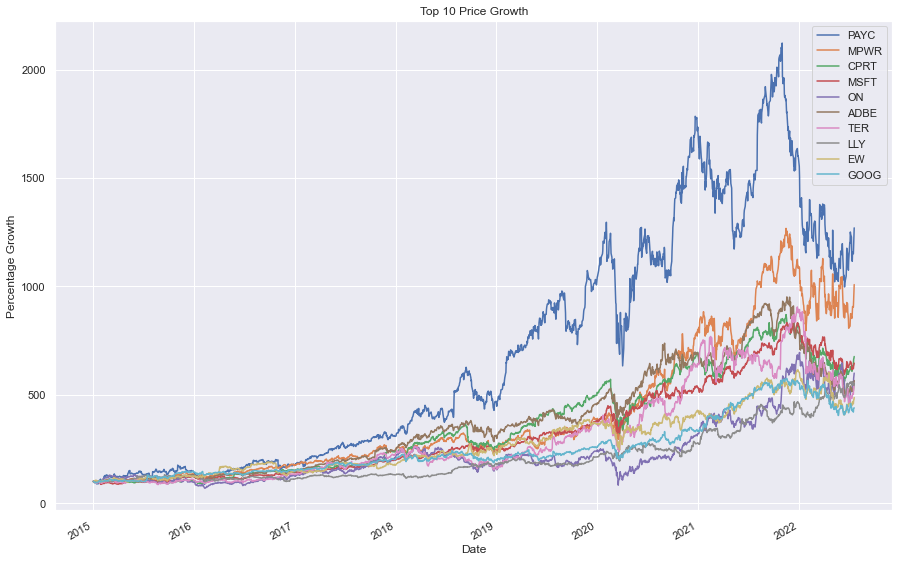

In [54]:
# Create returns and normalize data. Plot top 10 stocks by percentage growth

filtered_returns = filtered_stocks.pct_change()[1:]
filtered_returns

normalized_data = (filtered_stocks/filtered_stocks.iloc[0])*100
top_10 = ((normalized_data.iloc[-1]-normalized_data.iloc[0])/normalized_data.iloc[0]).nlargest(n=10).index.to_list()

normalized_data[top_10].plot(figsize=(15,10))
plt.title('Top 10 Price Growth')
plt.xlabel('Date')
plt.ylabel('Percentage Growth')
plt.show()

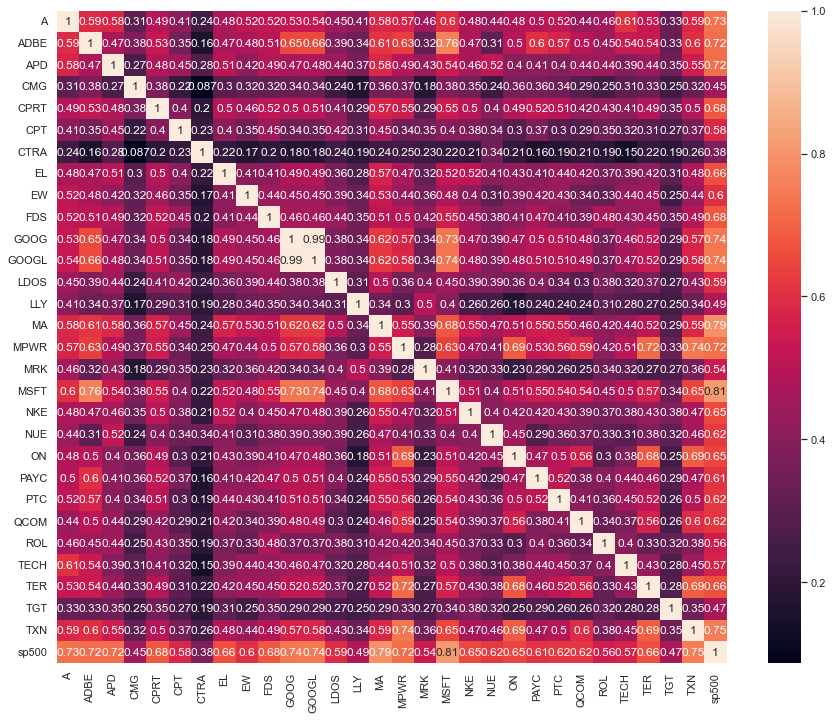

In [55]:
# Check correlations amongst the variables. A particularly important row would be the final row "sp500" which highlights the
# correlation of each stock with the S&P500 index. This is of particular importance as a well diversified portfolio should
# encompass negatively correlated stocks with the benchmark index. This fact will be discussed in the conclusion of the report.
correlations = filtered_returns.corr()

fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(correlations, annot=True, ax=ax)
plt.show()

#### Equally weighted portfolio and Weights Optimization

In [56]:
daily_returns = filtered_returns.iloc[:,:-1]

In [57]:
# Equally weighted portfolio

num_stocks = len(daily_returns.columns)
init_weights = np.repeat(1/num_stocks, num_stocks)
portfolio_ew = np.sum(daily_returns* init_weights, axis=1)

daily_cum_ret_ew = (1+portfolio_ew).cumprod()-1

expected_return_ew = np.sum(daily_returns.mean()*init_weights)*252
expected_vols_ew = np.sqrt(np.dot(init_weights.T, np.dot(daily_returns.cov()*252, init_weights)))
sharpe_ratio_ew = (expected_return_ew-rfr)/expected_vols_ew

print('The Equally Weighted Portfolio Expected Return is',round(expected_return_ew,2))  
print('The Equally Weighted Portfolio Expected Volatility is',round(expected_vols_ew,2))  
print('The Equally Weighted Portfolio Sharpe Ratio is',round(sharpe_ratio_ew,2))                           

The Equally Weighted Portfolio Expected Return is 0.23
The Equally Weighted Portfolio Expected Volatility is 0.21
The Equally Weighted Portfolio Sharpe Ratio is 0.98


In [58]:
# Monte Carlo simulation for optimal weight generation

n = 100000 # configure n for number of simulations
weights = np.zeros((n,len(daily_returns.columns)))
expected_returns = np.zeros(n) 
expected_vols = np.zeros(n)
sharpe_ratios = np.zeros(n)
rfr = 0.0291

for i in range(n):
    weight = np.random.random(len(daily_returns.columns))
    weight /= weight.sum()
    weights[i] = weight
    
    expected_returns[i] = np.sum(daily_returns.mean()*weight)*252 
    expected_vols[i] = np.sqrt(np.dot(weight.T, np.dot(daily_returns.cov()*252, weight)))
    sharpe_ratios[i] = (expected_returns[i]-rfr)/expected_vols[i]

#### Max Sharpe Ratio

In [59]:
# get position of the max sharpe ratio portfolio and clean weights. Calculate daily returns and cumulative daily returns

weights_msr = weights[sharpe_ratios.argmax()]

cleaned_weights_msr = pd.DataFrame(weights_msr)
cleaned_weights_msr.index = daily_returns.columns
cleaned_weights_msr.rename(columns={cleaned_weights_msr.columns[0] : 'weights'}, inplace=True)
cleaned_weights_msr = cleaned_weights_msr.sort_values(by='weights', ascending=False)

portfolio_msr = np.sum(daily_returns * weights_msr, axis=1)
daily_cum_ret_msr = (1+portfolio_msr).cumprod()-1

cleaned_weights_msr

,weights
PAYC,0.079251
ROL,0.078704
CPRT,0.073954
LLY,0.072486
MPWR,0.066257
TER,0.058745
LDOS,0.057227
MA,0.056020
A,0.048034
TECH,0.045706


In [60]:
# MSR expected return volatility

print('The Expected Return for the MSR Portfolio is',round(expected_returns[sharpe_ratios.argmax()],2))
print('The Expected Volatility for the MSR Portfolio is',round(expected_vols[sharpe_ratios.argmax()],2))
print('The Sharpe ratio for the MSR Portfolio is',round(sharpe_ratios[sharpe_ratios.argmax()],2))

The Expected Return for the MSR Portfolio is 0.26
The Expected Volatility for the MSR Portfolio is 0.22
The Sharpe ratio for the MSR Portfolio is 1.07


#### Minimum Volatility

In [61]:
# Get position of the min volatility portfolio and clean weights. Calculate daily returns and cumulative daily returns

weights_gmv = weights[expected_vols.argmin()]

cleaned_weights_gmv = pd.DataFrame(weights_gmv)
cleaned_weights_gmv.index = daily_returns.columns
cleaned_weights_gmv.rename(columns={cleaned_weights_gmv.columns[0] : 'weights'}, inplace=True)
cleaned_weights_gmv = cleaned_weights_gmv.sort_values(by='weights', ascending=False)

portfolio_gmv = np.sum(daily_returns * weights_gmv, axis=1)
daily_cum_ret_gmv = (1+portfolio_gmv).cumprod()-1

cleaned_weights_gmv

,weights
MRK,0.076189
ROL,0.075561
TXN,0.073275
LLY,0.066910
TGT,0.059584
CPRT,0.057172
LDOS,0.057043
GOOG,0.054686
CPT,0.051663
GOOGL,0.045684


In [62]:
# GMV expected return, volatility and Sharpe ratio

print('The Expected Return for the GMV Portfolio is',round(expected_returns[expected_vols.argmin()],2))
print('The Expected Volatility for the GMV Portfolio is',round(expected_vols[expected_vols.argmin()],2))
print('The Sharpe ratio for the GMV Portfolio is',round(sharpe_ratios[expected_vols.argmin()],2))

The Expected Return for the GMV Portfolio is 0.21
The Expected Volatility for the GMV Portfolio is 0.18
The Sharpe ratio for the GMV Portfolio is 0.99


#### Market Cap weighted portfolio

In [63]:
# Calculate daily returns and cumulative daily returns for the MCap portfolio

market_cap = piotroskiscore[['marketCap']].loc[chosen_stocks]
mcap_weights = market_cap/np.sum(market_cap)

portfolio_mcap = np.sum(daily_returns.mul(np.array(mcap_weights).reshape(-1)), axis=1)
daily_cum_ret_mcap = (1+portfolio_mcap).cumprod()-1

mcap_weights

,marketCap
symbol,
A,0.005068
ADBE,0.025662
APD,0.007878
CMG,0.005243
CPRT,0.003755
CPT,0.002062
CTRA,0.003219
EL,0.012793
EW,0.008217


In [64]:
# Expected return, expected volatility and Sharpe ratio for the MCap portfolio

expected_returns_mcap = np.sum(daily_returns.mean()*weight)*252 
expected_vol_mcap = np.sqrt(np.dot(mcap_weights.T, np.dot(daily_returns.cov()*252, mcap_weights)))[0][0]
sharpe_ratios_mcap = (expected_returns_mcap-rfr)/expected_vol_mcap

print('The Expected Return for the MCap Portfolio is',round(expected_returns_mcap,2))
print('The Expected Volatility for the MCap Portfolio is',round(expected_vol_mcap,2))
print('The Sharpe ratio for the MCap Portfolio is',round(sharpe_ratios_mcap,2))

The Expected Return for the MCap Portfolio is 0.23
The Expected Volatility for the MCap Portfolio is 0.23
The Sharpe ratio for the MCap Portfolio is 0.87


In [65]:
# Here we will calculate the cumulative returns for the S&P500. This benchmark has been included to compare the strategy
# against investing in the benchmark index. 

sp500_cum = (1+sp500_data.pct_change()[1:]).cumprod()-1
sp500_cum.head()

,sp500
Date,
2015-01-05,-0.018278
2015-01-06,-0.027009
2015-01-07,-0.015693
2015-01-08,0.001914
2015-01-09,-0.006506


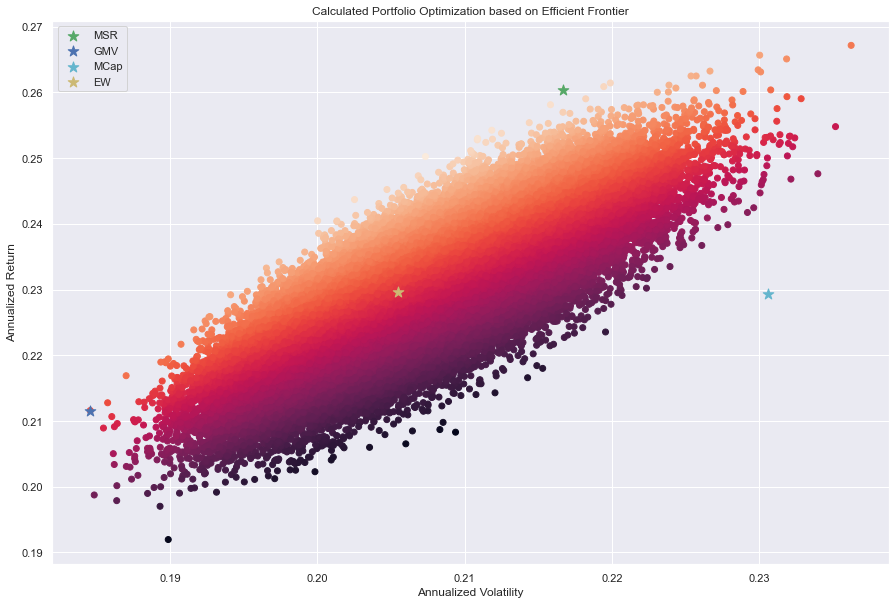

In [66]:
# plotting the efficient frontier for all 100,000 portfolios generated by the Monte Carlo simulation

fig, ax = plt.subplots(figsize=(15,10))

ax.scatter(expected_vols, expected_returns, c=sharpe_ratios)
ax.scatter(expected_vols[sharpe_ratios.argmax()], expected_returns[sharpe_ratios.argmax()], c='g', label='MSR', s=125, marker='*')
ax.scatter(expected_vols[expected_vols.argmin()], expected_returns[expected_vols.argmin()], c='b', label='GMV', s=125, marker='*')
ax.scatter(expected_vol_mcap, expected_returns_mcap, c='c', label='MCap', s=125, marker='*')
ax.scatter(expected_vols_ew, expected_return_ew, c='y', label='EW', s=125, marker='*')

plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
ax.set_xlabel('Annualized Volatility')
ax.set_ylabel('Annualized Return')
plt.legend()
plt.show()

EW Date
2022-07-15    3.559137
2022-07-18    3.521883
2022-07-19    3.676850
2022-07-20    3.733551
2022-07-21    3.811614
dtype: float64
MCap Date
2022-07-15    3.945829
2022-07-18    3.862916
2022-07-19    4.021719
2022-07-20    4.047225
2022-07-21    4.091374
dtype: float64
GMV Date
2022-07-15    3.156779
2022-07-18    3.117276
2022-07-19    3.243386
2022-07-20    3.263835
2022-07-21    3.331828
dtype: float64
MSR Date
2022-07-15    4.619497
2022-07-18    4.570663
2022-07-19    4.773388
2022-07-20    4.848921
2022-07-21    4.959415
dtype: float64


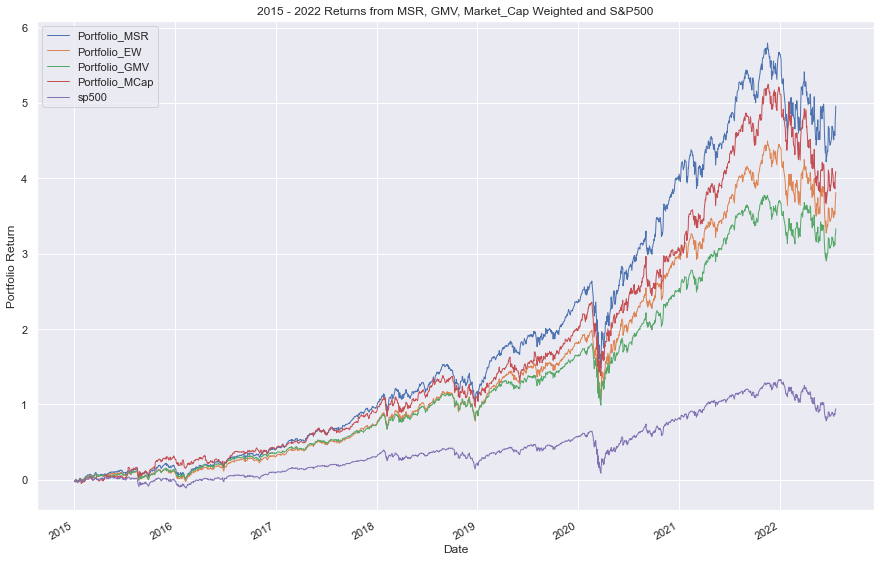

In [67]:
print('EW',daily_cum_ret_ew.tail())
print('MCap',daily_cum_ret_mcap.tail())
print('GMV',daily_cum_ret_gmv.tail())
print('MSR',daily_cum_ret_msr.tail())

fig, ax = plt.subplots()
daily_cum_ret_msr.plot(figsize=(15,10), label='Portfolio_MSR', linewidth=1)
daily_cum_ret_ew.plot(label='Portfolio_EW', linewidth=1)
daily_cum_ret_gmv.plot(label='Portfolio_GMV', linewidth=1)
daily_cum_ret_mcap.plot(label='Portfolio_MCap', linewidth=1)
sp500_cum.plot(ax=ax, label='S&P500', linewidth=1)


plt.title('2015 - 2022 Returns from MSR, GMV, Market_Cap Weighted and S&P500')
plt.ylabel('Portfolio Return')
plt.legend()
plt.show()

##### Had we invested £10,000 in the MSR portfolio in 2015 how much would it be in 2022?

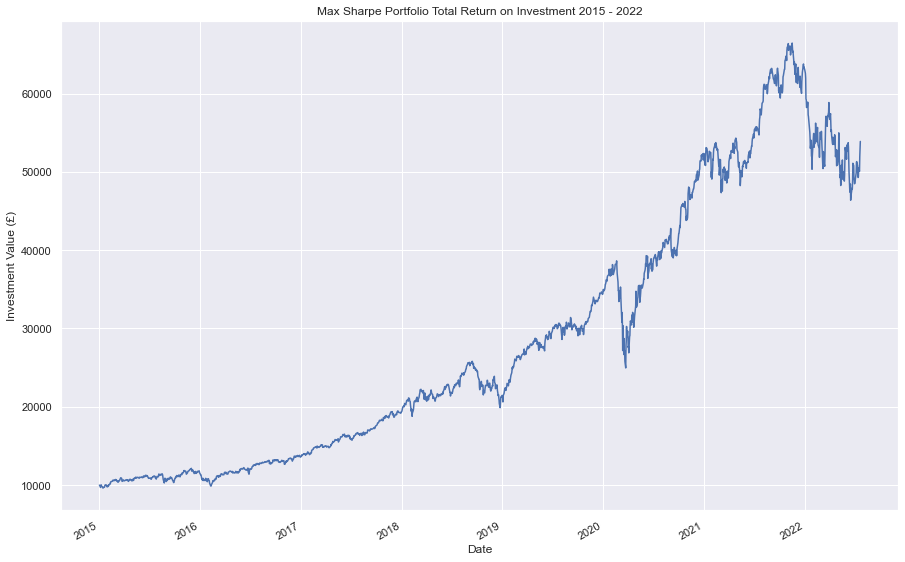

In [68]:
# We need to divide the normalized data by 100 to get actual values as we muliplied by 100 previously to get percentage values

total_return_invest = np.sum((normalized_data.iloc[:,:-1]/100)*weights_msr*10000, axis=1) 

fig, ax = plt.subplots()
total_return_invest.plot(figsize=(15,10),ax=ax)

plt.title('Max Sharpe Portfolio Total Return on Investment 2015 - 2022')
plt.ylabel('Investment Value (£)')
plt.xlabel('Date')
plt.show()

In [69]:
# Summarize results from the equally weighted, market cap, minimum variance and max Sharpe portfolios

results = pd.DataFrame(columns=[
    'Annualized Return', 
    'Annualized Volatility',
    'Sharpe Ratio',
    'Skewness',
    'Kurtosis'],
                    
    index=['Equal. Weight. Portfolio',
           'Market Cap Portfolio',
          'Global Min Var Portfolio',
          'Max Sharpe Portfolio'])

results['Annualized Return'] = [expected_return_ew*100,
                             expected_returns_mcap*100, 
                            expected_returns[expected_vols.argmin()]*100,
                            expected_returns[sharpe_ratios.argmax()]*100]

results['Annualized Volatility'] = [expected_vols_ew*100,
                                 expected_vol_mcap*100,
                                expected_vols[expected_vols.argmin()]*100,
                                expected_vols[sharpe_ratios.argmax()]*100]

results['Sharpe Ratio'] = [sharpe_ratio_ew,
                       sharpe_ratios_mcap,
                       sharpe_ratios[expected_vols.argmin()],
                       sharpe_ratios[sharpe_ratios.argmax()]]

results['Skewness'] = [portfolio_ew.skew(),
                   portfolio_mcap.skew(),
                    portfolio_gmv.skew(),
                    portfolio_msr.skew()]

results['Kurtosis'] = [portfolio_ew.kurt(),
                   portfolio_mcap.kurt(),
                    portfolio_gmv.kurt(),
                    portfolio_msr.kurt()]

results

,Annualized Return,Annualized Volatility,Sharpe Ratio,Skewness,Kurtosis
Equal. Weight. Portfolio,22.962036,20.546393,0.975939,-0.356196,10.681592
Market Cap Portfolio,22.933044,23.055361,0.868477,-0.165676,7.736655
Global Min Var Portfolio,21.159445,18.460226,0.988582,-0.391071,10.882987
Max Sharpe Portfolio,26.037282,21.667074,1.067393,-0.252372,10.071414


In [70]:
portfolio_sectors = sectors.loc[chosen_stocks]

sector_totals = portfolio_sectors.value_counts()
sector_totals_1 = sector_totals/(sector_totals.sum())
sector_totals_1*100

# Here we can see the portfolio of chosen stocks has an overweight position in I.T and to a lesser extent Health Care. 
# To optimise we could potentially remove some companies in I.T and increase securities in either Cosumer Staples, Energy, 
# Financials or Real Estate.

sector                
Information Technology    34.482759
Health Care               17.241379
Consumer Discretionary    10.344828
Industrials               10.344828
Communication Services     6.896552
Materials                  6.896552
Consumer Staples           3.448276
Energy                     3.448276
Financials                 3.448276
Real Estate                3.448276
dtype: float64

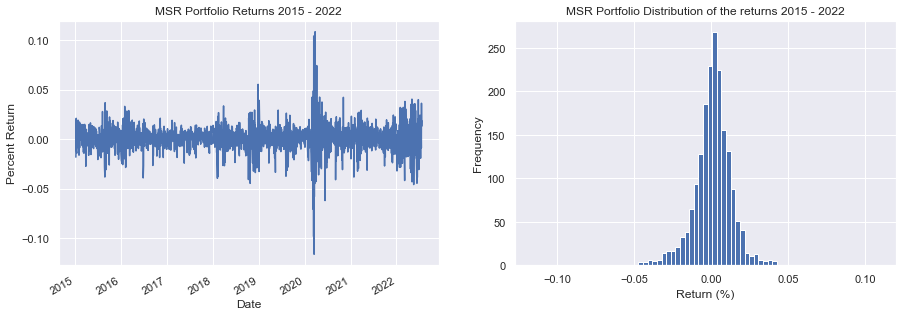

In [71]:
# Returns and Distribution of the max Sharpe portfolio

# Plotting the return as a percentage
plt.subplot(1,2,1)
portfolio_msr.plot(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Percent Return')
plt.title('MSR Portfolio Returns 2015 - 2022')

plt.subplot(1,2,2)
plt.hist(portfolio_msr, bins=75)
plt.xlabel('Return (%)')
plt.ylabel('Frequency')
plt.title('MSR Portfolio Distribution of the returns 2015 - 2022')
plt.show()

## Risk Management

### Parametric VaR and CVaR

In [72]:
# We multiply the returns by 100 to get the value in percentage form as we want our VaR/CVaR estimates to be shown as percent
portfolio_msr_pct = portfolio_msr*100

# Estimate the average daily return and the daily volatility
mu = np.mean(portfolio_msr_pct)
vol = np.std(portfolio_msr_pct)

# Set the VaR confidence levels to 90%, 95% and 99%
confidence_level_90 = 0.1
confidence_level_95 = 0.05
confidence_level_99 = 0.01

# Calculate VaR_90, VaR_95, VaR_99
var_90 = norm.ppf(confidence_level_90, mu, vol)
var_95 = norm.ppf(confidence_level_95, mu, vol)
var_99 = norm.ppf(confidence_level_99, mu, vol)

# Calculate Parametric CVaR_90, CVaR_95, CVaR_99
cvar_90 = portfolio_msr_pct[portfolio_msr_pct <= var_90].mean()
cvar_95 = portfolio_msr_pct[portfolio_msr_pct <= var_95].mean()
cvar_99 = portfolio_msr_pct[portfolio_msr_pct <= var_99].mean()
                           
    
# The volatility indicates the daily standard deviation. We can see there is a daily standard deviation of 1.3%
print('Mean: ', str(round(mu,5)), '\nVolatility: ', str(round(vol,2)))
print('\nVaR(90): ', str(round(var_90,2)), '\nCVaR(90): ', str(round(cvar_90,2)))
print('\nVaR(95): ', str(round(var_95,2)), '\nCVaR(95): ', str(round(cvar_95,2)))
print('\nVaR(99): ', str(round(var_99,2)), '\nCVaR(99): ', str(round(cvar_99,2)))

Mean:  0.10332 
Volatility:  1.36

VaR(90):  -1.65 
CVaR(90):  -2.79

VaR(95):  -2.14 
CVaR(95):  -3.32

VaR(99):  -3.07 
CVaR(99):  -4.28


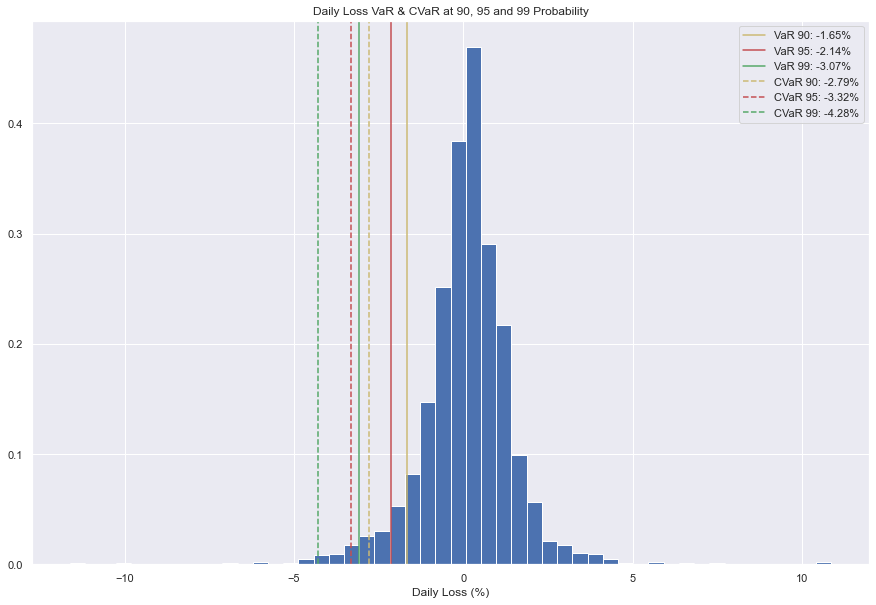

In [94]:
# Plot the VaR_90, VaR_95 and VaR_99
sorted_rets = sorted(portfolio_msr_pct)

fig, ax = plt.subplots(figsize = (15, 10))
plt.hist(sorted_rets, density=True, stacked=True, bins=50)

# Plot 90, 95 and 99 VaR and CVaR
plt.axvline(x=var_90, color="y", linestyle="-", label='VaR 90: {0:.2f}%'.format(var_90))
plt.axvline(x=var_95, color="r", linestyle="-", label='VaR 95: {0:.2f}%'.format(var_95))
plt.axvline(x=var_99, color="g", linestyle="-", label='VaR 99: {0:.2f}%'.format(var_99))
plt.axvline(x=cvar_90, color='y', linestyle='--', label='CVaR 90: {0:.2f}%'.format(cvar_90))
plt.axvline(x=cvar_95, color='r', linestyle='--', label='CVaR 95: {0:.2f}%'.format(cvar_95))
plt.axvline(x=cvar_99, color='g', linestyle='--', label='CVaR 99: {0:.2f}%'.format(cvar_99))
plt.xlabel('Daily Loss (%)')
plt.title('Daily Loss VaR & CVaR at 90, 95 and 99 Probability')
plt.legend()
plt.show()

#### Scaling risk with time

In [74]:
# The .ppf() function calculates the probability for a given normal distribution value, while the 
# .cdf() function calculates the normal distribution value for which a given probability is the required value. 
# These are inverse of each other in this particular sense.

# Calculating the probability of the returns dropping more than 50% in 252 days

# Estimate the average daily return and annualize
mu = np.mean(portfolio_msr_pct)
mu252 = 252*mu

# Estimate the daily volatility and annualize
vol = np.std(portfolio_msr_pct)
vol252 = np.sqrt(252)*vol

print(norm.cdf(-0.5, mu252, vol252)*100)

# Here we can see that there is an 11% probability that the returns will drop more than 50% in 252 days

11.026932669682543


In [75]:
# VaR_95 for the next 30 days. You can extend the time horizon, however, 30 days was chosen due to rebalancing every 30 days.

# Aggregate forecasted VaR
forecasted_values = np.empty([30, 2])

# Loop through each forecast period
for i in range(0,30):
    forecasted_values[i, 0] = i
    forecasted_values[i, 1] = var_95*np.sqrt(i+1)
    
forecasted_values

# Here we can see that there is a 95% probability that losses over the next 30 days won't exceed 11.2%

array([[  0.        ,  -2.14114292],
       [  1.        ,  -3.02803335],
       [  2.        ,  -3.70856832],
       [  3.        ,  -4.28228584],
       [  4.        ,  -4.78774111],
       [  5.        ,  -5.24470761],
       [  6.        ,  -5.66493168],
       [  7.        ,  -6.05606671],
       [  8.        ,  -6.42342875],
       [  9.        ,  -6.77088842],
       [ 10.        ,  -7.10136768],
       [ 11.        ,  -7.41713664],
       [ 12.        ,  -7.72000058],
       [ 13.        ,  -8.01142321],
       [ 14.        ,  -8.29261086],
       [ 15.        ,  -8.56457167],
       [ 16.        ,  -8.82815841],
       [ 17.        ,  -9.08410006],
       [ 18.        ,  -9.3330256 ],
       [ 19.        ,  -9.57548223],
       [ 20.        ,  -9.81194949],
       [ 21.        , -10.04285049],
       [ 22.        , -10.2685607 ],
       [ 23.        , -10.48941523],
       [ 24.        , -10.70571459],
       [ 25.        , -10.91772952],
       [ 26.        , -11.12570496],
 

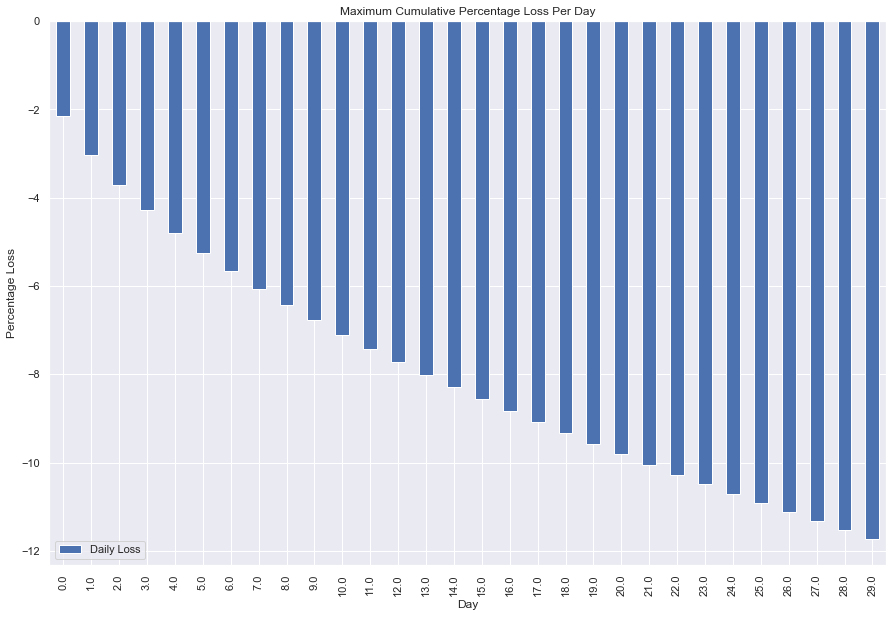

In [76]:
# Plotting the cumulative expected daily loss at the 95% confidence. The way to read this graph is that the value on a given day
# highlights the 95% probability that losses over that many days will not exceed the value shown. For example, on day 14 we can
# say that over the next 14 days there is a 95% likelihood that losses will not exceed 8%.

daily_loss = pd.DataFrame(forecasted_values).set_index(0)
daily_loss = daily_loss.rename(columns={1:'Daily Loss'})
daily_loss.plot(kind='bar', figsize = (15, 10))
plt.title('Maximum Cumulative Percentage Loss Per Day')
plt.xlabel('Day')
plt.ylabel('Percentage Loss')
plt.show()

In [92]:
# Chosen companies
final_portfolio = tickers.set_index('Symbol')
final_portfolio = final_portfolio.loc[chosen_stocks,['Security','GICS Sector', 'GICS Sub-Industry']]
final_portfolio

,Security,GICS Sector,GICS Sub-Industry
Symbol,,,
A,Agilent Technologies,Health Care,Health Care Equipment
ADBE,Adobe Inc.,Information Technology,Application Software
APD,Air Products and Chemicals,Materials,Industrial Gases
CMG,Chipotle Mexican Grill,Consumer Discretionary,Restaurants
CPRT,Copart,Industrials,Diversified Support Services
CPT,Camden Property Trust,Real Estate,Residential REITs
CTRA,Coterra,Energy,Oil & Gas Exploration & Production
EL,The Estée Lauder Companies,Consumer Staples,Personal Products
EW,Edwards Lifesciences,Health Care,Health Care Equipment
